# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores from ND-GAIN variables and more.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [4]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

df.info

df.describe

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

In [5]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='Value')

#print(melted_df)

In [30]:
melted_df.describe()

,Year
count,5983.000000
mean,2005.000000
std,8.945019
min,1990.000000
25%,1997.000000
50%,2005.000000
75%,2013.000000
max,2020.000000


In [25]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso             5983 non-null   object 
 1   Country/Region  5983 non-null   object 
 2   unit            5983 non-null   object 
 3   Year            5983 non-null   float64
 4   Value           5983 non-null   object 
dtypes: float64(1), object(4)
memory usage: 233.8+ KB


In [6]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['Value'] = melted_df['Value'].astype(float)

In [7]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year    Value
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


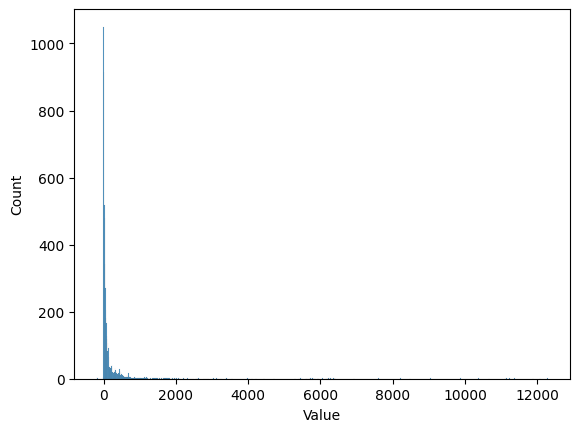

In [46]:
sns.histplot(data=melted_df, x='Value', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [20]:
import pandas as pd

melted_df['log_value'] = melted_df['Value'].apply(lambda x: np.log(x) if x > 0 else 0)

# If you want to apply the transformation to multiple columns at once:
# data[['feature1', 'feature2', ...]] = data[['feature1', 'feature2', ...]].apply(lambda x: np.log(x) if x > 0 else 0)

# Alternatively, you can use numpy directly for element-wise log transformation
# import numpy as np
# data['log_transformed_feature'] = np.log(data['feature'])

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year    Value  log_value
0  CHN          China  MtCO2e  1990.0  2892.41   7.969845
1  USA  United States  MtCO2e  1990.0  5448.74   8.603140
2  IND          India  MtCO2e  1990.0  1020.11   6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74   7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84   7.039520


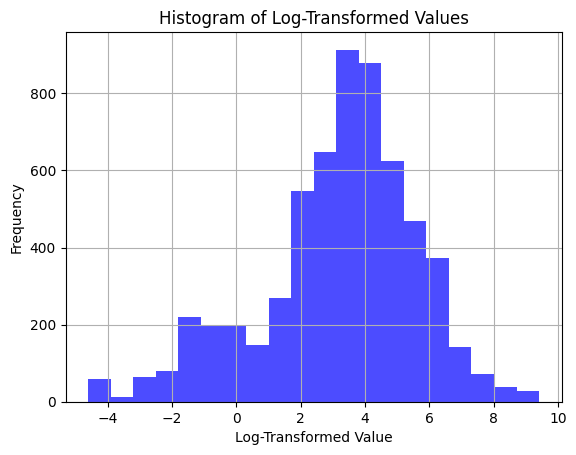

In [24]:
plt.hist(melted_df['log_value'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Log-Transformed Values')
plt.xlabel('Log-Transformed Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

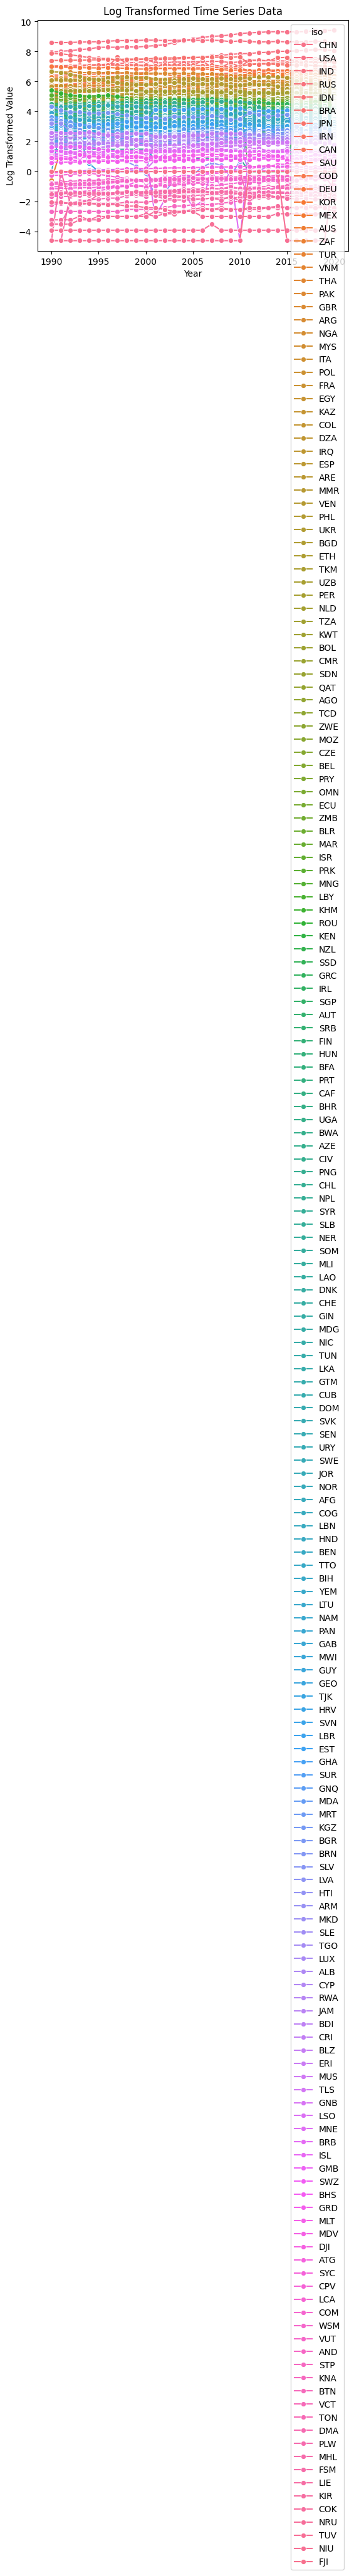

In [27]:
sns.lineplot(data=melted_df, x='Year', y='log_value', hue='iso', marker='o')

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

## Add predictors to our GHG-dataset

ValueError: could not convert string to float: 'CHN'

## Splitting the data set

In [25]:
#Assigning x and y 
X = melted_df['Year']  # Selecting columns containing features
y = melted_df['log_value']  # Selecting the column containing the target variable


In [26]:
from sklearn.model_selection import GroupShuffleSplit

# Assuming 'X' contains your features and 'y' contains your target variable
# 'groups' contains the grouping variable, such as country names
# 'data' is your DataFrame containing all the data

# Initialize GroupShuffleSplit with desired parameters
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets
for train_index, test_index in gss.split(X, y, groups=melted_df['iso']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (4774,) (4774,)
Test set shape: (1209,) (1209,)


In [ ]:
performances = []

In [17]:
mean_value = y_train.mean()
model_name = 'dummy'
for y,nsplit in zip([y_train, y_test],
                    ['train', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

ValueError: Input contains NaN.

## Baseline model 